# CS184a Project - UBC Ovarian Cancer Subtype Classification

## Imports for Model and Data

In [422]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Image processing
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

# Format and filter potential warnings and errors
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Image and Model Hyperparameters

In [423]:
CONFIG = {
    "seed": 42,
    "epochs": 3,
    "img_size": 512,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "num_classes": 30,
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 0.0001,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 0.000001,
    "T_max": 500,
    "weight_decay": 0.000001,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

### Set Seed

In [424]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [425]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = '/kaggle/input/UBC-OCEAN/train_thumbnails'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'

In [426]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}_thumbnail.png"
#    return f"{TRAIN_DIR}/{image_id}.png"

## Retrieve Data from CSV Files and Link Them to Thumbnails

In [427]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))

In [428]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
2,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
3,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
4,431,HGSC,39991,40943,False,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...
...,...,...,...,...,...,...
508,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...
509,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...
510,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...
511,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...


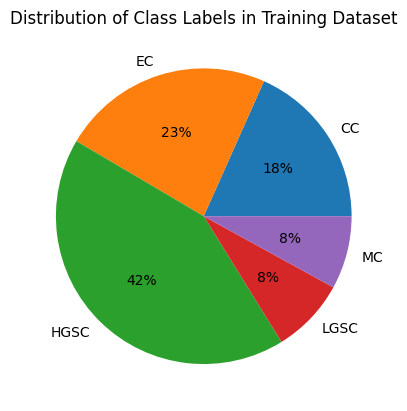

In [429]:
import matplotlib.pyplot as plt
# Assuming 'df' is your DataFrame with a 'label' column

counts = [0, 0, 0, 0, 0]
labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']

for index, row in df.iterrows():
    counts[labels.index(row['label'])] += 1

fig, ax = plt.subplots(1, 1)
ax.set_title('Distribution of Class Labels in Training Dataset')
ax.pie(counts, labels=labels, autopct='%1.0f%%')

plt.show()


In [430]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [431]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

38

## Create Folds for k-Fold Cross Validation

In [432]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.label)):
      df.loc[val_ , "kfold"] = int(fold)

## Format Data

### Data Class

Will be used to get relevant image information from thumbnails that are linked to csv file entries.



In [433]:
class UBCData(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

## Format and Transform Images

In [434]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

## GeM Pooling Implementation

Implementation taken from the following [link](https://amaarora.github.io/posts/2020-08-30-gempool.html)

In [435]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

## Creating a Model

In [436]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True, checkpoint_path=None):
        super(UBCModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        inputs = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        # self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        # self.pooling = nn.AdaptiveMaxPool2d((1, 1))
        self.linear = nn.Linear(inputs, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        out = self.model(images)
        out = self.pooling(out).flatten(1)
        out = self.linear(out)
        return out

    
model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'], checkpoint_path=CONFIG['checkpoint_path'])
model.to(CONFIG['device']);

## Implement a Loss Function

For this problem, we can use the built-in CrossEntropyLoss function as our loss function.



In [437]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

## Training (for a sinle epoch)

In [438]:
def train_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    data_size = 0
    current_loss = 0.0
    current_acc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )
        
        current_loss += (loss.item() * batch_size)
        current_acc  += acc.item()
        data_size += batch_size
        
        epoch_loss = current_loss / data_size
        epoch_acc = current_acc / data_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_acc

## Validation (for a single epoch)

In [439]:
@torch.inference_mode()
def validation_epoch(model, dataloader, device, epoch):
    model.eval()
    
    data_size = 0
    current_loss = 0.0
    current_acc = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )

        current_loss += (loss.item() * batch_size)
        current_acc  += acc.item()
        data_size += batch_size
        
        epoch_loss = current_loss / data_size
        epoch_acc = current_acc / data_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_acc

## Train the Model (over all epochs)

In [440]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_epoch_acc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_acc = train_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_acc = validation_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train Accuracy'].append(train_epoch_acc)
        history['Valid Accuracy'].append(val_epoch_acc)
        
        # deep copy the model
        if best_epoch_acc <= val_epoch_acc:
            print(f"{b_}Validation Accuracy Improved ({best_epoch_acc} ---> {val_epoch_acc})")
            best_epoch_acc = val_epoch_acc
            best_model = copy.deepcopy(model.state_dict())
            PATH = "Acc{:.2f}_Loss{:.4f}_epoch{:.0f}.bin".format(best_epoch_acc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Accuracy: {:.4f}".format(best_epoch_acc))
    
    # load best model weights
    model.load_state_dict(best_model)
    
    return model, history

## Prepare for Training Execution

### Fetch Scheduler

In [441]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

### Prepare Loaders

In [442]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = UBCData(df_train, transforms=data_transforms["train"])
    valid_dataset = UBCData(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [443]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

### Initialize Optimizer and Scheduler

In [444]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

## Execute Training

In [445]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 2/2 [00:11<00:00,  5.63s/it, Epoch=1, LR=7.76e-5, Valid_Acc=0.437, Valid_Loss=1.42]


Validation Accuracy Improved (-inf ---> 0.4368932038834951)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.65s/it, Epoch=2, LR=3.06e-5, Valid_Acc=0.476, Valid_Loss=1.28]


Validation Accuracy Improved (0.4368932038834951 ---> 0.47572815533980584)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.70s/it, Epoch=3, LR=1.68e-6, Valid_Acc=0.515, Valid_Loss=1.26]


Validation Accuracy Improved (0.47572815533980584 ---> 0.5145631067961165)
Model Saved

Training complete in 0h 2m 26s
Best Accuracy: 0.5146


## Write Results to CSV

In [446]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

## Result Visualization

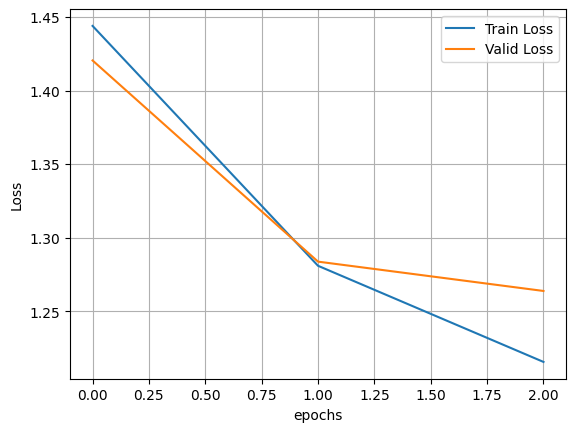

In [447]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

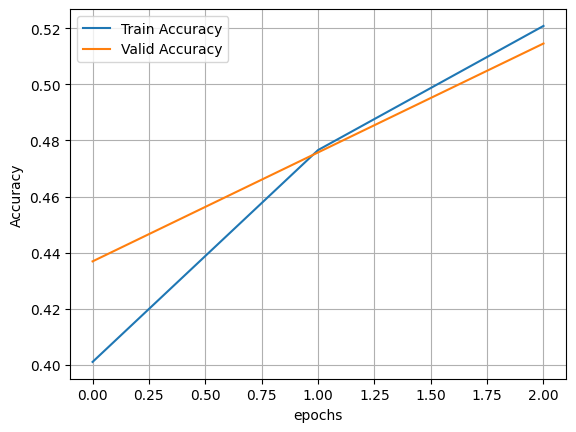

In [448]:
plt.plot( range(history.shape[0]), history["Train Accuracy"].values, label="Train Accuracy")
plt.plot( range(history.shape[0]), history["Valid Accuracy"].values, label="Valid Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()